# Loan classification

## Imports and connections

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

## Data load

In [2]:
df = pd.read_csv("~/Coding/PycharmProjects/Education/projects/Neural Networks/datasets/cardio_train.csv", sep=";",
                 index_col="id")

In [3]:
df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
99996,19066,2,183,105.0,180,90,3,1,0,1,0,1


## DA

1. Age | Objective Feature | age | int (days)
2. Height | Objective Feature | height | int (cm) |
3. Weight | Objective Feature | weight | float (kg) |
4. Gender | Objective Feature | gender | categorical code | 1: women, 2: men
5. Systolic blood pressure | Examination Feature | ap_hi | int |
6. Diastolic blood pressure | Examination Feature | ap_lo | int |
7. Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
8. Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
9. Smoking | Subjective Feature | smoke | binary |
10. Alcohol intake | Subjective Feature | alco | binary |
11. Physical activity | Subjective Feature | active | binary |
12. Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

In [4]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Наш датасет не имеет пропусков, выбросы на первый взгляд не видны, нужно лишь немного обработать данные

Преобразуем возраст в нормальный вид(из дней в года)

In [5]:
df["age"] = df["age"] / 365.25
df["age"] = df["age"].astype(int)

Бинаризуем данные гендера

In [6]:
df["gender"] = df["gender"].map({2: 1, 1: 0})

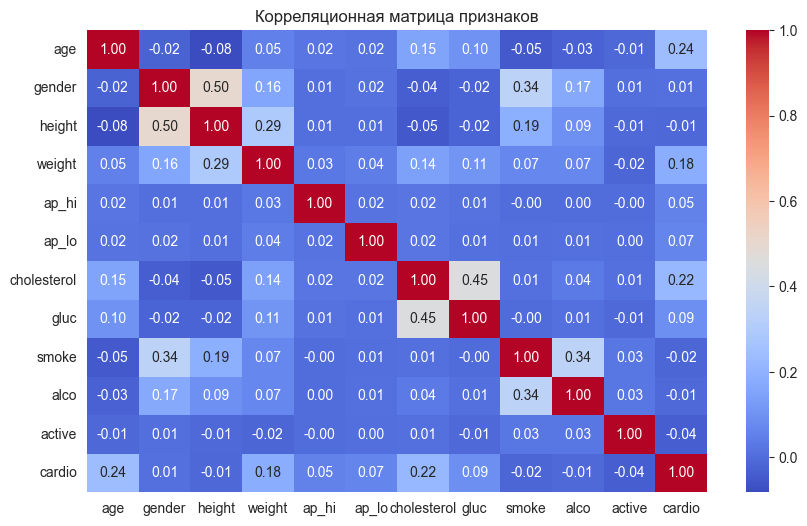

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляционная матрица признаков")
plt.show()

In [8]:
df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,50,1,168,62.0,110,80,1,1,0,0,1,0
1,55,0,156,85.0,140,90,3,1,0,0,1,1
2,51,0,165,64.0,130,70,3,1,0,0,0,1
3,48,1,169,82.0,150,100,1,1,0,0,1,1
4,47,0,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99993,52,1,168,76.0,120,80,1,1,1,0,1,0
99995,61,0,158,126.0,140,90,2,2,0,0,1,1
99996,52,1,183,105.0,180,90,3,1,0,1,0,1


## Models

### Preparing for training

In [9]:
def check_metrics(y_train, y_test, y_pred_train, y_pred_test, y_proba_train=None, y_proba_test=None):
    def compute_metrics(y_true, y_pred, y_proba=None):
        metrics = {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, average='binary'),
            "Recall": recall_score(y_true, y_pred, average='binary'),
            "F1": f1_score(y_true, y_pred, average='binary')
        }
        if y_proba is not None:
            if y_proba.shape[1] > 1:
                y_proba = y_proba[:, 1]
            metrics["ROC AUC"] = roc_auc_score(y_true, y_proba)
        else:
            metrics["ROC AUC"] = np.nan
        return metrics


    train_metrics = compute_metrics(y_train, y_pred_train, y_proba_train)
    test_metrics = compute_metrics(y_test, y_pred_test, y_proba_test)

    df = pd.DataFrame([train_metrics, test_metrics], index=["Train", "Test"]).round(4)
    print("Метрики классификации:")
    display(df)

    print("\nМатрица ошибок (Train):")
    print(confusion_matrix(y_train, y_pred_train))
    print("\nМатрица ошибок (Test):")
    print(confusion_matrix(y_test, y_pred_test))

    print("\nОтчёт по классам (Test):")
    print(classification_report(y_test, y_pred_test, digits=3))

    if (y_proba_train is not None) and (y_proba_test is not None):
        if y_proba_train.shape[1] > 1:
            y_proba_train = y_proba_train[:, 1]
        if y_proba_test.shape[1] > 1:
            y_proba_test = y_proba_test[:, 1]

        fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)

        auc_train = roc_auc_score(y_train, y_proba_train)
        auc_test = roc_auc_score(y_test, y_proba_test)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr_train, tpr_train, label=f"Train (AUC = {auc_train:.3f})", linestyle="--")
        plt.plot(fpr_test, tpr_test, label=f"Test (AUC = {auc_test:.3f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Random")
        plt.title("ROC-кривые", fontsize=14)
        plt.xlabel("False Positive Rate (1 - Specificity)", fontsize=12)
        plt.ylabel("True Positive Rate (Recall)", fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()

In [10]:
X = df.drop(columns="cardio")
y = df["cardio"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2004
)

### Liner model

In [11]:
num_features = ["age", "height", "weight", "ap_hi", "ap_lo"]
cat_features = ["cholesterol", "gluc"]
binary_features = ["gender", "smoke", "alco", "active"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_features),
        ("bin", "passthrough", binary_features)
    ]
)

In [12]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

all_columns = preprocessor.get_feature_names_out()

for i in range(len(all_columns)):
    all_columns[i] = all_columns[i].split("__")[1]

In [13]:
X_train_log = pd.DataFrame(X_train_transformed, columns=all_columns, index=X_train.index)
X_test_log = pd.DataFrame(X_test_transformed, columns=all_columns, index=X_test.index)

y_train_log = y_train.copy()
y_test_log = y_test.copy()

#### Analytical solution

In [14]:
X_train_ = np.hstack([np.ones((X_train_log.shape[0], 1)), X_train_log])
X_test_ = np.hstack([np.ones((X_test_log.shape[0], 1)), X_test_log])

y_train_ = y_train_log.values.reshape(-1, 1)

In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [16]:
theta = np.zeros((X_train_.shape[1], 1))
alpha = 0.01
n_iterations = 10000

for i in range(n_iterations):
    z = X_train_ @ theta
    h = sigmoid(z)
    gradient = (X_train_.T @ (h - y_train_)) / len(y_train_)
    theta -= alpha * gradient

In [17]:
y_log_prob_train_analytical = sigmoid(X_train_ @ theta)
y_log_prob_test_analytical = sigmoid(X_test_ @ theta)

In [18]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_log, y_log_prob_train_analytical)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_log, y_log_prob_test_analytical)

i_train = np.argmax(tpr_train - fpr_train)
i_test = np.argmax(tpr_test - fpr_test)

threshold_train = thresholds_train[i_train]
threshold_test = thresholds_test[i_test]

In [19]:
y_log_pred_train_analytical = (y_log_prob_train_analytical >= threshold_train).astype(int)
y_log_pred_test_analytical = (y_log_prob_test_analytical >= threshold_test).astype(int)

#### Library solution

In [20]:
model_log = LogisticRegression(max_iter=1000, solver="lbfgs")
model_log.fit(X_train_log, y_train_log)

LogisticRegression(max_iter=1000)

In [21]:
y_log_prob_train_lib = model_log.predict_proba(X_train_log)
y_log_prob_test_lib = model_log.predict_proba(X_test_log)

y_log_pred_train_lib = model_log.predict(X_train_log)
y_log_pred_test_lib = model_log.predict(X_test_log)

#### Result

##### Feature

In [22]:
features = ["Intercept"] + list(X_train_log)

comparison = pd.DataFrame({
    "Feature": features,
    "Analytical": theta.flatten(),
    "Sklearn": np.hstack([model_log.intercept_, model_log.coef_.flatten()])
})

comparison

,Feature,Analytical,Sklearn
0,Intercept,0.263925,0.321351
1,age,0.425054,0.369179
2,height,-0.074520,-0.041936
3,weight,0.330346,0.231713
4,ap_hi,1.165459,5.486025
5,ap_lo,0.235979,0.057530
6,cholesterol_1,-0.450629,-0.407517
7,cholesterol_2,0.085161,0.019737
8,cholesterol_3,0.629393,0.705167
9,gluc_1,0.143650,0.194935


##### Metrics

Проверяем метрики для аналитического решения, при этом проверяем, чтобы не было переобучения

Метрики классификации:


,Accuracy,Precision,Recall,F1,ROC AUC
Train,0.6725,0.6798,0.6555,0.6674,0.7326
Test,0.6696,0.6714,0.6478,0.6594,0.7311



Матрица ошибок (Train):
[[19264  8667]
 [ 9671 18398]]

Матрица ошибок (Test):
[[4899 2191]
 [2434 4476]]

Отчёт по классам (Test):
              precision    recall  f1-score   support

           0      0.668     0.691     0.679      7090
           1      0.671     0.648     0.659      6910

    accuracy                          0.670     14000
   macro avg      0.670     0.669     0.669     14000
weighted avg      0.670     0.670     0.669     14000



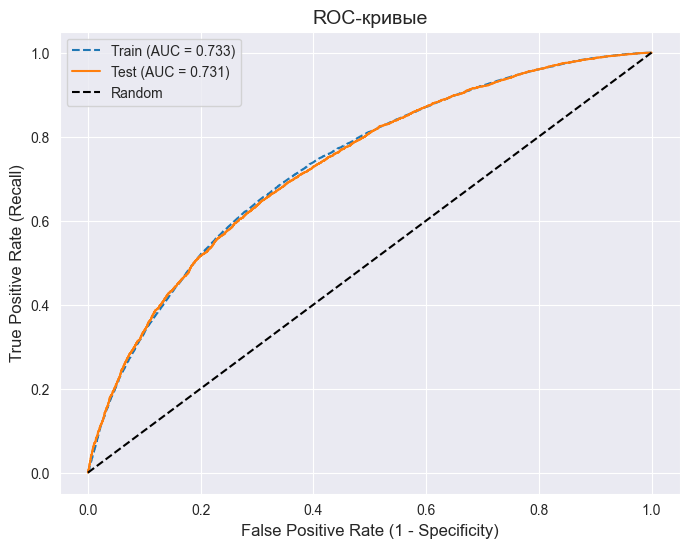

In [23]:
check_metrics(y_train_log, y_test_log, y_log_pred_train_analytical, y_log_pred_test_analytical, y_log_prob_train_analytical, y_log_prob_test_analytical)

Проверяем метрики для билиотечного решения, при этом проверяем, чтобы не было переобучения

Метрики классификации:


,Accuracy,Precision,Recall,F1,ROC AUC
Train,0.7192,0.7396,0.6788,0.7079,0.7832
Test,0.7239,0.7398,0.6796,0.7084,0.7850



Матрица ошибок (Train):
[[21222  6709]
 [ 9015 19054]]

Матрица ошибок (Test):
[[5438 1652]
 [2214 4696]]

Отчёт по классам (Test):
              precision    recall  f1-score   support

           0      0.711     0.767     0.738      7090
           1      0.740     0.680     0.708      6910

    accuracy                          0.724     14000
   macro avg      0.725     0.723     0.723     14000
weighted avg      0.725     0.724     0.723     14000



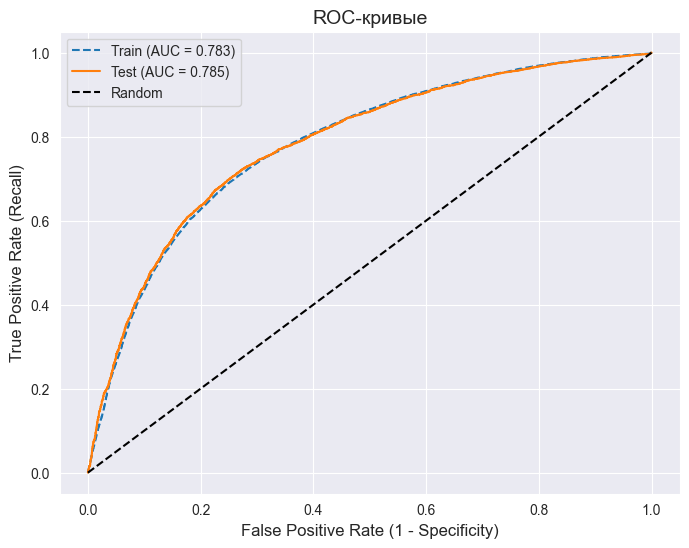

In [24]:
check_metrics(y_train_log, y_test_log, y_log_pred_train_lib, y_log_pred_test_lib, y_log_prob_train_lib,
              y_log_prob_test_lib)

### Decision tree

#### Analytical solution

In [25]:
def entropy(y):
    p = y.value_counts(normalize=True)
    return -np.sum(p * np.log2(p))


def IG(X_col, y):
    total_entropy = entropy(y)
    threshold = X_col.median()
    left = y[X_col <= threshold]
    right = y[X_col > threshold]
    weighted_entropy = (len(left) / len(y)) * entropy(left) + (len(right) / len(y)) * entropy(right)
    return total_entropy - weighted_entropy, threshold

In [26]:
def build_tree(X, y, min_ig=0.01, min_samples=10, depth=0, max_depth=3):
    if len(y) < min_samples or depth >= max_depth:
        return {"class": y.mode()[0]}

    ig_values = {}
    thresholds = {}
    for col in X.columns:
        ig, thr = IG(X[col], y)
        ig_values[col] = ig
        thresholds[col] = thr

    best_feature = max(ig_values, key=ig_values.get)
    if ig_values[best_feature] < min_ig:
        return {"class": y.mode()[0]}

    threshold = thresholds[best_feature]
    left_idx = X[best_feature] <= threshold
    right_idx = X[best_feature] > threshold

    left_tree = build_tree(X[left_idx], y[left_idx], min_ig, min_samples, depth + 1, max_depth)
    right_tree = build_tree(X[right_idx], y[right_idx], min_ig, min_samples, depth + 1, max_depth)

    return {"feature": best_feature, "threshold": threshold,
            "left": left_tree, "right": right_tree}

In [27]:
def predict_analytic(tree, X_row):
    if "class" in tree:
        return tree["class"]
    feature = tree["feature"]
    threshold = tree["threshold"]
    if X_row[feature] <= threshold:
        return predict_analytic(tree["left"], X_row)
    else:
        return predict_analytic(tree["right"], X_row)


In [28]:
analytic_tree = build_tree(X_train, y_train, min_ig=0.01, min_samples=10, max_depth=7)

y_tree_pred_train_analytical = X_train.apply(lambda row: predict_analytic(analytic_tree, row), axis=1)
y_tree_pred_test_analytical = X_test.apply(lambda row: predict_analytic(analytic_tree, row), axis=1)

#### Library solution

Найдем оптимальную глубину для библиотечного дерева

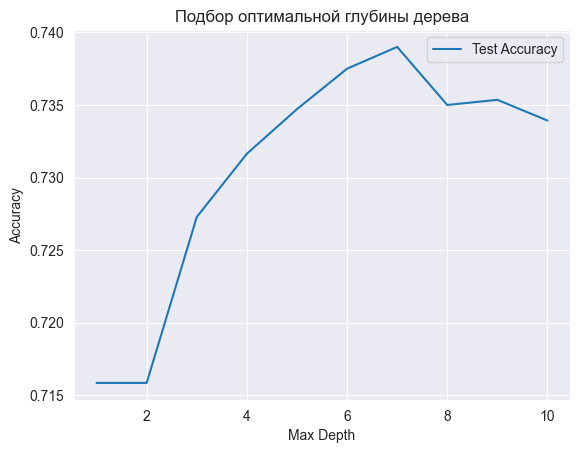

In [29]:
depths = range(1, 11)
train_acc = []
test_acc = []

for d in depths:
    model_tree_test = DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=2004, min_samples_leaf=10)
    model_tree_test.fit(X_train, y_train)
    test_acc.append(accuracy_score(y_test, model_tree_test.predict(X_test)))

plt.plot(depths, test_acc, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Подбор оптимальной глубины дерева')
plt.legend()
plt.show()

In [30]:
model_tree = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=10,
    random_state=2004
)
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=10,
                       random_state=2004)

In [31]:
y_tree_prob_train_lib = model_tree.predict_proba(X_train)
y_tree_prob_test_lib = model_tree.predict_proba(X_test)

y_tree_pred_train_lib = model_tree.predict(X_train)
y_tree_pred_test_lib = model_tree.predict(X_test)

#### Result

##### Metrics

Проверяем метрики для аналитического решения, при этом проверяем, чтобы не было переобучения

In [32]:
check_metrics(y_train, y_test, y_tree_pred_train_analytical, y_tree_pred_test_analytical)

Метрики классификации:


,Accuracy,Precision,Recall,F1,ROC AUC
Train,0.7253,0.7288,0.7199,0.7243,NaN
Test,0.7277,0.7250,0.7223,0.7236,NaN



Матрица ошибок (Train):
[[20411  7520]
 [ 7861 20208]]

Матрица ошибок (Test):
[[5197 1893]
 [1919 4991]]

Отчёт по классам (Test):
              precision    recall  f1-score   support

           0      0.730     0.733     0.732      7090
           1      0.725     0.722     0.724      6910

    accuracy                          0.728     14000
   macro avg      0.728     0.728     0.728     14000
weighted avg      0.728     0.728     0.728     14000



Проверяем метрики для библиотечного решения, при этом проверяем, чтобы не было переобучения

Метрики классификации:


,Accuracy,Precision,Recall,F1,ROC AUC
Train,0.7349,0.7668,0.6769,0.7190,0.8028
Test,0.7390,0.7637,0.6823,0.7207,0.7975



Матрица ошибок (Train):
[[22154  5777]
 [ 9070 18999]]

Матрица ошибок (Test):
[[5631 1459]
 [2195 4715]]

Отчёт по классам (Test):
              precision    recall  f1-score   support

           0      0.720     0.794     0.755      7090
           1      0.764     0.682     0.721      6910

    accuracy                          0.739     14000
   macro avg      0.742     0.738     0.738     14000
weighted avg      0.741     0.739     0.738     14000



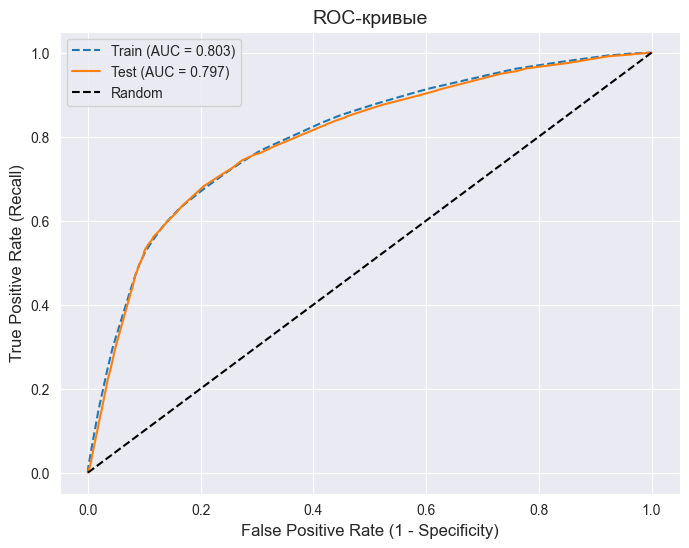

In [33]:
check_metrics(y_train, y_test, y_tree_pred_train_lib, y_tree_pred_test_lib, y_tree_prob_train_lib,
              y_tree_prob_test_lib)

##### Visualization

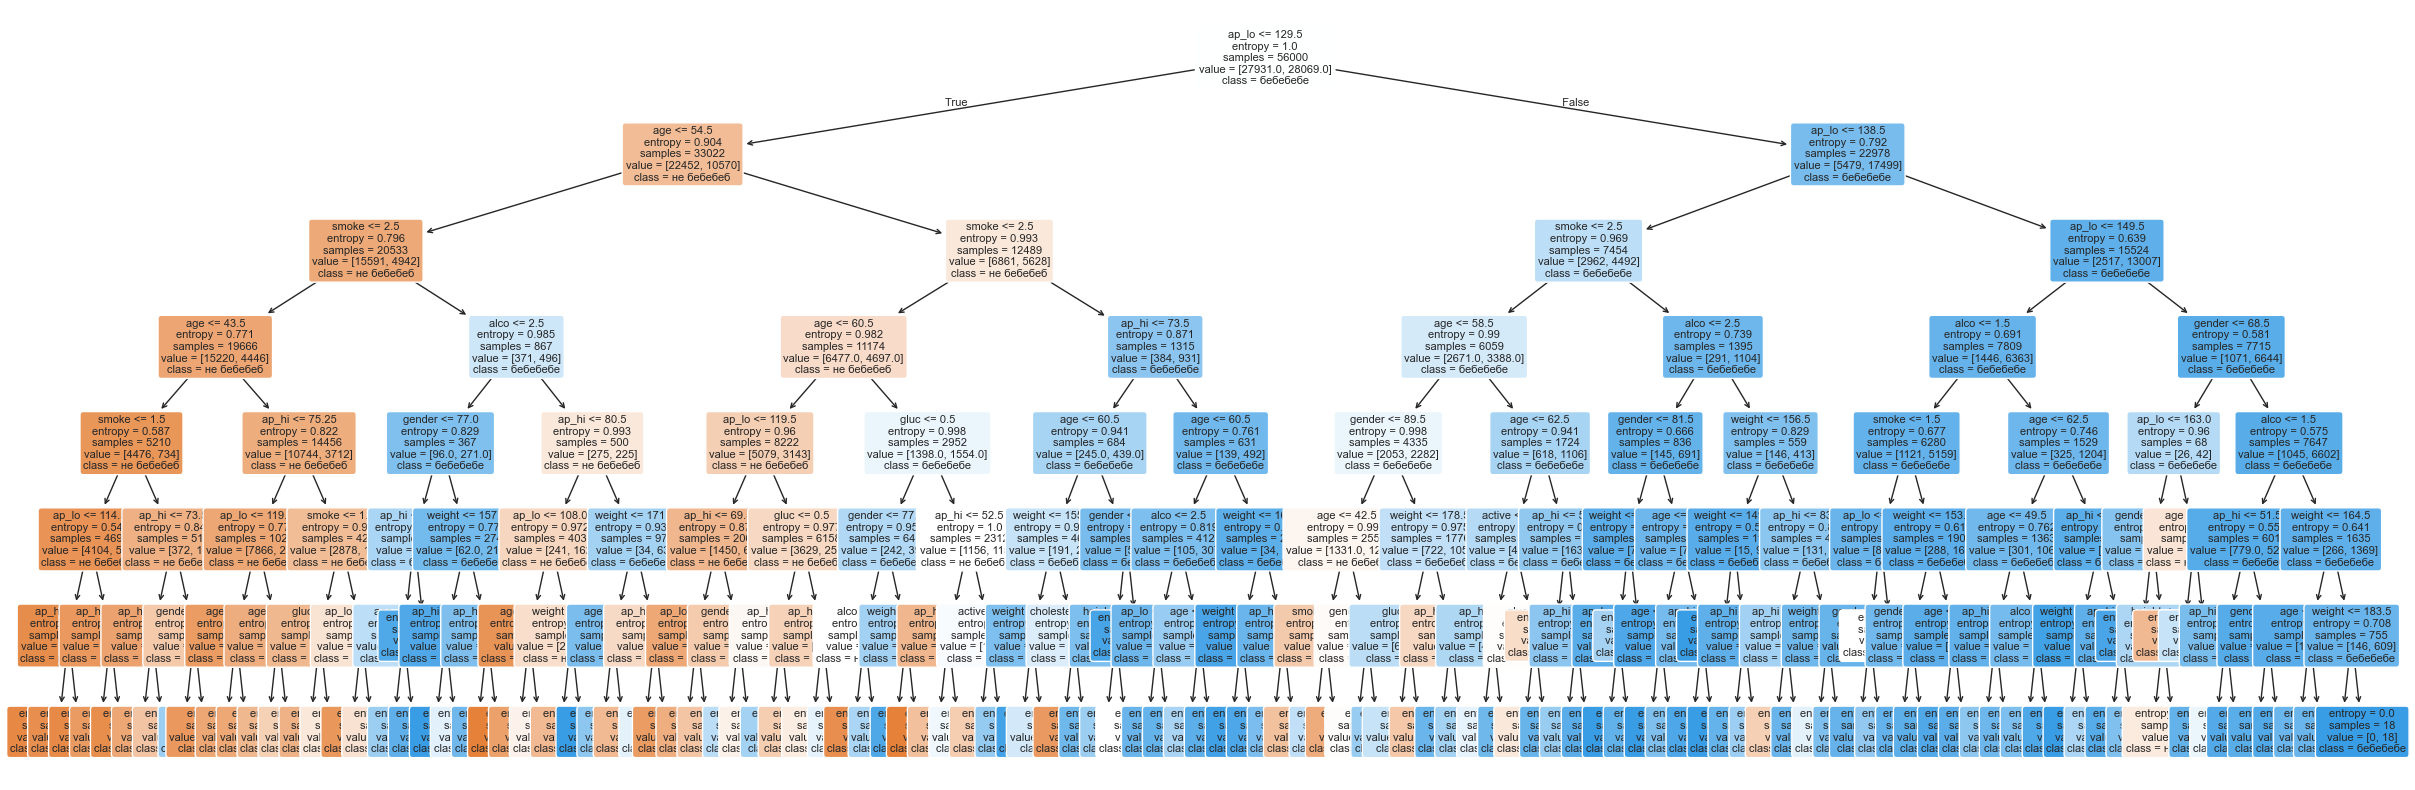

In [34]:
fig, axes = plt.subplots(figsize=(30, 10))
plot_tree(model_tree,
          feature_names=["age", "height", "weight", "ap_hi", "ap_lo", "gender", "smoke", "alco", "active",
                         "cholesterol", "gluc"],
          class_names=['не бебебеб', 'бебебебе'],
          filled=True,
          rounded=True,
          fontsize=8)
plt.show()

### Random Forest

In [35]:
model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=2004
)
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=2004)

In [40]:
y_rf_prob_train_lib = model_rf.predict_proba(X_train)
y_rf_prob_test_lib = model_rf.predict_proba(X_test)

y_rf_pred_train_lib = model_rf.predict(X_train)
y_rf_pred_test_lib = model_rf.predict(X_test)

##### Metrics

In [37]:
check_metrics(y_train, y_test, y_rf_pred_train_lib, y_rf_pred_test_lib, y_rf_prob_train_lib,
              y_rf_prob_test_lib)

IndexError: tuple index out of range

### Cat Boosting

#### Models

In [37]:
model_cat = CatBoostClassifier(
    iterations=2000,
    depth=7,
    learning_rate=0.01,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=2004,
)

model_cat.fit(X_train, y_train)

0:	total: 69.2ms	remaining: 2m 18s
1:	total: 75.1ms	remaining: 1m 15s
2:	total: 80.4ms	remaining: 53.5s
3:	total: 86.7ms	remaining: 43.3s
4:	total: 93.3ms	remaining: 37.2s
5:	total: 101ms	remaining: 33.5s
6:	total: 107ms	remaining: 30.5s
7:	total: 112ms	remaining: 27.9s
8:	total: 117ms	remaining: 25.9s
9:	total: 123ms	remaining: 24.4s
10:	total: 129ms	remaining: 23.3s
11:	total: 134ms	remaining: 22.3s
12:	total: 140ms	remaining: 21.3s
13:	total: 145ms	remaining: 20.5s
14:	total: 150ms	remaining: 19.9s
15:	total: 156ms	remaining: 19.3s
16:	total: 161ms	remaining: 18.8s
17:	total: 167ms	remaining: 18.3s
18:	total: 172ms	remaining: 17.9s
19:	total: 177ms	remaining: 17.5s
20:	total: 182ms	remaining: 17.2s
21:	total: 188ms	remaining: 16.9s
22:	total: 194ms	remaining: 16.7s
23:	total: 200ms	remaining: 16.5s
24:	total: 206ms	remaining: 16.3s
25:	total: 211ms	remaining: 16s
26:	total: 217ms	remaining: 15.9s
27:	total: 223ms	remaining: 15.7s
28:	total: 228ms	remaining: 15.5s
29:	total: 233ms	re

In [ ]:
y_cat_prob_train_lib = model_cat.predict_proba(X_train)
y_cat_prob_test_lib = model_cat.predict_proba(X_test)

y_cat_pred_train_lib = model_cat.predict(X_train)
y_cat_pred_test_lib = model_cat.predict(X_test)

#### Metrics

In [ ]:
check_metrics(y_train, y_test, y_cat_pred_train_lib, y_cat_pred_test_lib, y_cat_prob_train_lib,
              y_cat_prob_test_lib)